In [2]:
using FileIO
using Images, ImageView
using Formatting

In [3]:
function roundAround(x, low, high)
  if x < low
    low
  elseif x > high
    high
  else
    round(Int32, x)
  end
end

roundAround (generic function with 1 method)

In [99]:
function forwardTransform(M, P, outSize=nothing)
  rows, cols = size(P)
  if outSize == nothing
    outSize = size(P)
  end
  out = zeros(eltype(P), outSize)
  for index in CartesianIndices(P)
    y, x = Tuple(index)
    newindex = M * [x; y; 1]
    newindex ./= newindex[end]
    x1 = roundAround(newindex[1], 1, cols)
    y1 = roundAround(newindex[2], 1, rows)
    out[y1, x1] = P[index]
  end
  out
end

forwardTransform (generic function with 2 methods)

In [92]:
function backwardTransform(algo, M, P, outSize=nothing)
  M = inv(M)
  rows, cols = size(P)
  if outSize == nothing
    outSize = size(P)
  end
  out = zeros(eltype(P), outSize)

  for index in CartesianIndices(out)
    y, x = Tuple(index)
    sourceIndex = M * [x; y; 1]
    sourceIndex ./= sourceIndex[end]
    x1, y1 = round.(Int32, sourceIndex)
    if (x1 < 1 || y1 < 1 || x1 > cols || y1 > rows)
      continue
    end
    out[index] = P[y1, x1]
  end
  out
end

backwardTransform (generic function with 2 methods)

In [6]:
function genMatrix(what, params...)
  M = zeros(Float32, (3,3))
  M[3, 3] = 1

  if what == "scale"
    if length(params) < 2
      error("Scale requires two parameter (x, y)")
    end
    x, y = params
    printfmt("Scale with x = {}; y = {}\n", x, y)
    M[1, 1] = x
    M[2, 2] = y
  elseif what == "translate"
    if length(params) < 2
      error("Translate requires two parameter (dx, dy)")
    end
    dx, dy = params
    M[1, 1] = 1
    M[2, 2] = 1
    M[1, 3] = dx
    M[2, 3] = dy
  elseif what == "rotate"
    if length(params) < 2
      error("Rotate requires one parameter (theta, isRadian)")
    end
    theta = params[1]
    isRadian = 1
    if length(params) >= 2
      isRadian = params[2]
    end

    if isRadian == 1
      M[1, 1] =  cos(theta)
      M[1, 2] =  -sin(theta)
      M[2, 1] =  sin(theta)
      M[2, 2] =  cos(theta)
    else
      M[1, 1] =  cosd(theta)
      M[1, 2] =  -sind(theta)
      M[2, 1] =  sind(theta)
      M[2, 2] =  cosd(theta)
    end
  elseif what == "shear"
    if length(params) < 4
      error("Rotate requires four parameter (a, b, c, d)")
    end
    a,b,c,d = params
    M[1, 1] = a
    M[1, 2] = b
    M[2, 1] = c
    M[2, 2] = d
  else
    error(printfmt("Matrix of {} is unknown\n", what))
  end
  M
end

genMatrix (generic function with 1 method)

3×3 Array{Float32,2}:
 0.707107  -0.707107   500.0  
 0.707107   0.707107  -207.107
 0.0        0.0          1.0  

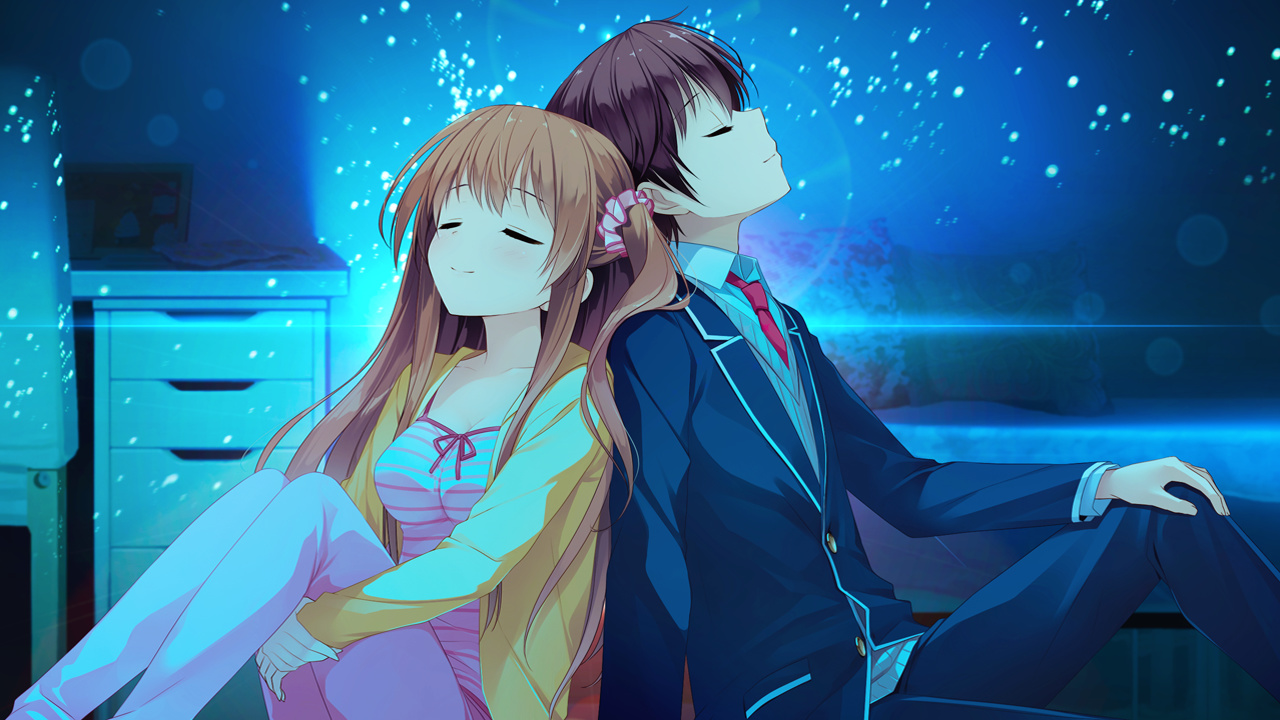

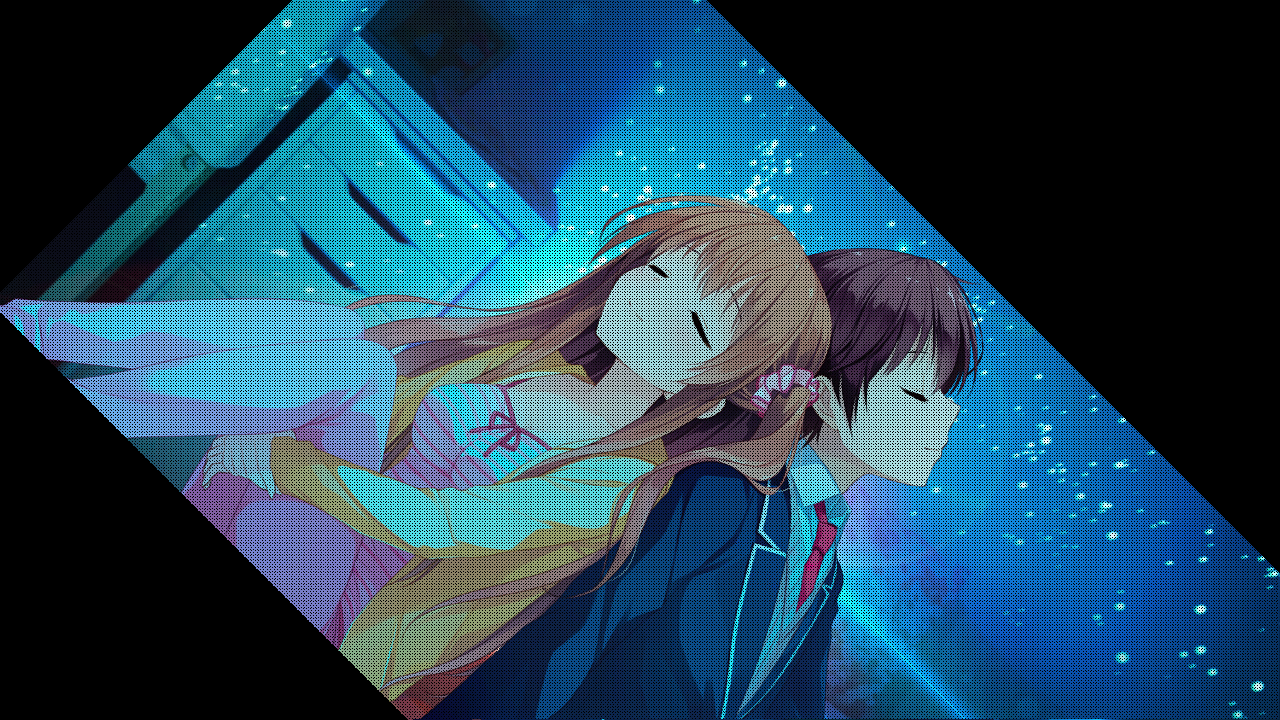

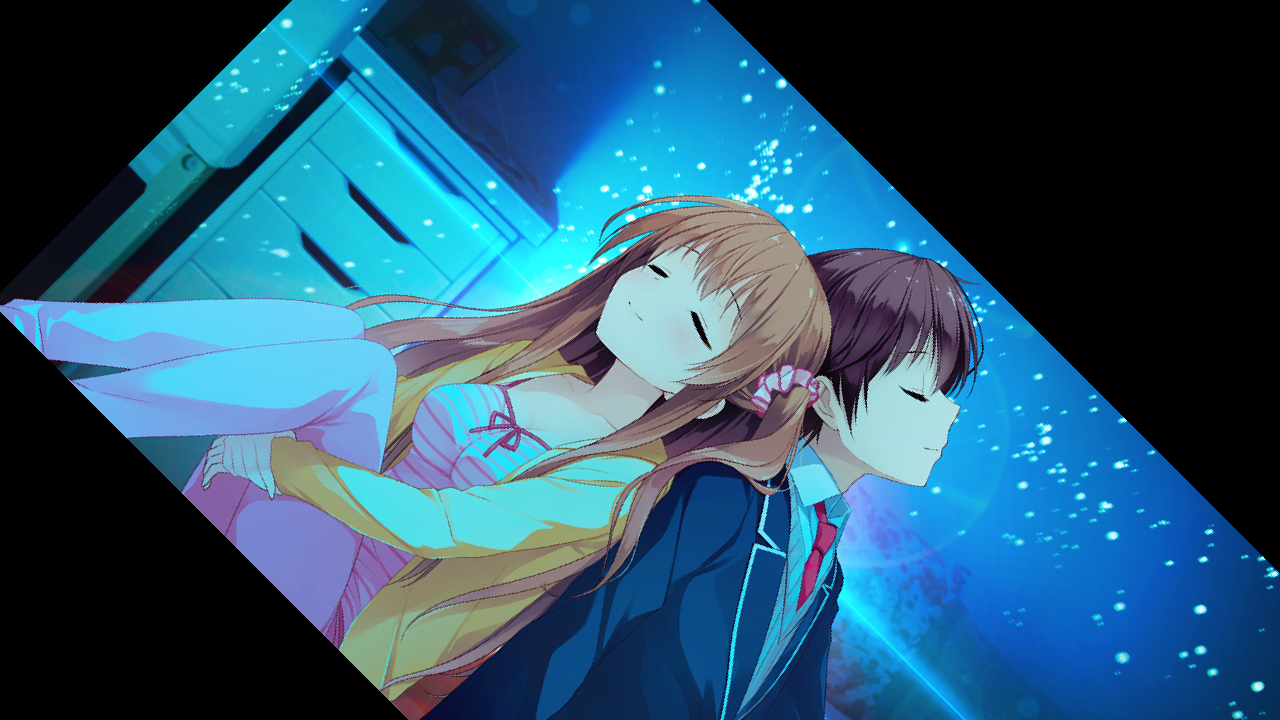

In [100]:
img = load("../images/f124074.jpg")
Matrixes = [
    # do last
    genMatrix("translate", 500, 500),
    genMatrix("rotate", 45, false),
    genMatrix("translate", -500, -500)    
    # do first
]

M = *(Matrixes...)
display(M)

display(img)

forward = forwardTransform(M, img)
display(forward)

backward = backwardTransform("zero", M, img)
display(backward)

In [102]:
function createProjectiveMatrix(points)
  if length(points) != 4
    error("Not correct number of point")
  end

  A = zeros(Int64, 2*length(points), 8)
  B = zeros(Int64, 2*length(points), 1)
  for i in 1:length(points)
    x, y, x1, y1 = points[i]
    A[2*i - 1,:] = [x y 1 0 0 0 -x*x1 -x1*y]
    A[2*i,:] = [0 0 0 x y 1 -x*y1 -y*y1]
    B[2*i - 1] = x1
    B[2*i] = y1
  end

  H = vcat(A\B, 1)
  M = reshape(H, (3,3))'
  
  # display(M)
  M
end

function projectiveTransform(picture, points, outSize)
  M = createProjectiveMatrix(points)
  backwardTransform("zero", M, picture, outSize)
end

projectiveTransform (generic function with 1 method)

8×8 Array{Int64,2}:
   55   187  1     0     0  0       -55      -187
    0     0  0    55   187  1       -55      -187
 1276   619  1     0     0  0  -1919104   -930976
    0     0  0  1276   619  1     -1276      -619
 1447  1761  1     0     0  0  -2176288  -2648544
    0     0  0  1447  1761  1  -2917152  -3550176
  166  1819  1     0     0  0      -166     -1819
    0     0  0   166  1819  1   -334656  -3667104

8×1 Array{Int64,2}:
    1
    1
 1504
    1
 1504
 2016
    1
 2016

3×3 LinearAlgebra.Adjoint{Float64,Array{Float64,2}}:
  0.886982     -0.060257     -36.5144
 -0.500302      1.41336     -235.78  
 -0.000275854   8.95484e-5     1.0   

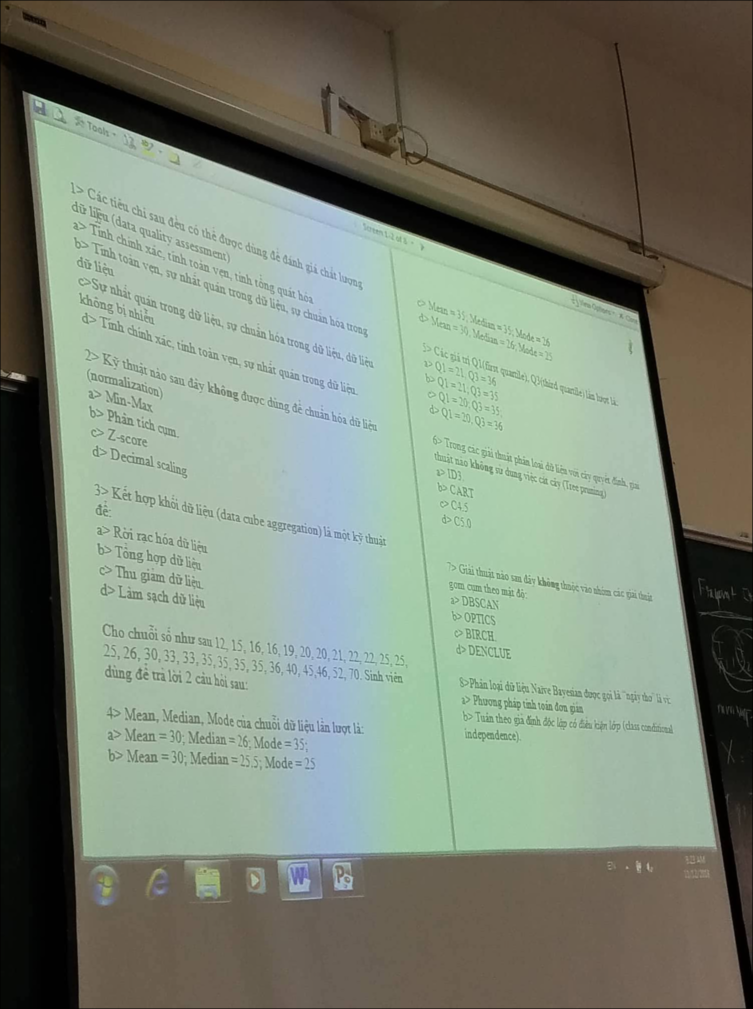

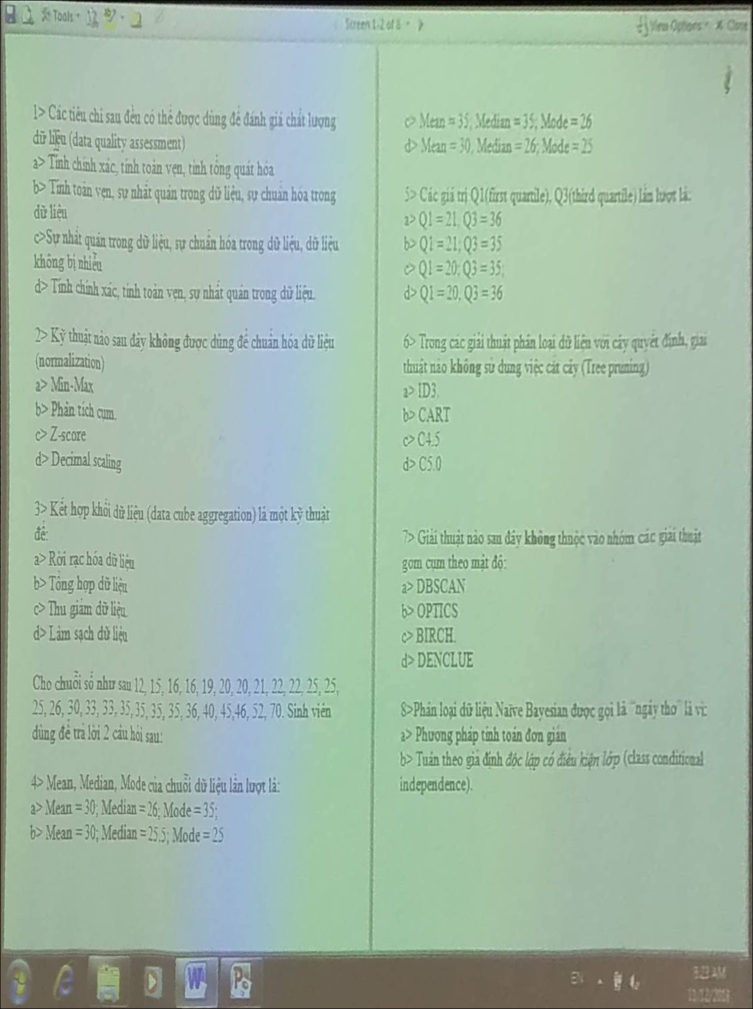

In [104]:
img = load("../images/aaa.jpg")
row, col = size(img)
points = [
  # [x y x1 y1],
  [55 187 1 1],
  [1276 619 col 1],
  [1447 1761 col row],
  [166 1819 1 row]
]

# out = projectiveTransform(img,points)

M = createProjectiveMatrix()
out = backwardTransform("zero", M, picture)

display(img)
display(out)